In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import models, transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [8]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 5
NUM_CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# Load CIFAR10 dataset
train_dataset = CIFAR10(root='/Users/nikita/Desktop/CIFAR10-main', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='/Users/nikita/Desktop/CIFAR10-main', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [12]:
# Load pre-trained ResNet18 and modify the final layer
classifier = models.resnet18(pretrained=True)
classifier.fc = nn.Linear(classifier.fc.in_features, NUM_CLASSES)
classifier = classifier.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


In [13]:
# Training loop
losses = []

for epoch in range(EPOCHS):
    classifier.train()
    running_loss = 0.0
    for images_batch, labels_batch in train_loader:
        images_batch, labels_batch = images_batch.to(DEVICE), labels_batch.to(DEVICE)
        optimizer.zero_grad()
        output = classifier(images_batch)
        loss = criterion(output, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images_batch.size(0)
    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch: {epoch+1}, Loss: {epoch_loss:.4f}")
    losses.append(epoch_loss)

Epoch: 1, Loss: 1.0890
Epoch: 2, Loss: 0.7555
Epoch: 3, Loss: 0.6152
Epoch: 4, Loss: 0.5013
Epoch: 5, Loss: 0.4135


In [15]:
 if (epoch + 1) % 5 == 0:
        torch.save(classifier.state_dict(), f"cifar10_model_epoch_{epoch+1}.pth")

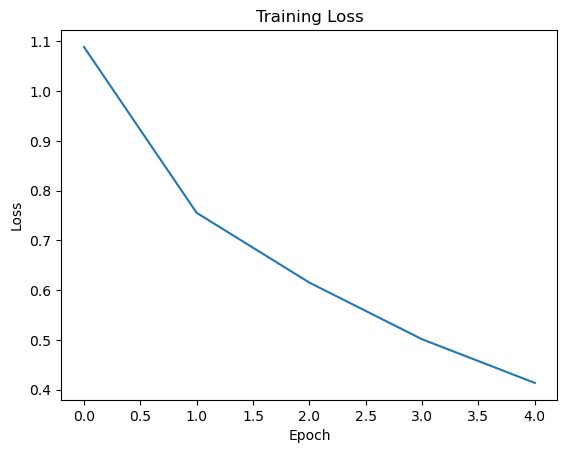

In [16]:
# Plot training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [19]:
# Evaluation
classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy on test set: {(100 * correct / total):.2f}%")

Accuracy on test set: 79.64%


In [21]:
# Define the list of class names manually
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Print classification report with manually defined class names
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.83      0.81      0.82      1000
  automobile       0.85      0.91      0.88      1000
        bird       0.77      0.74      0.76      1000
         cat       0.57      0.70      0.63      1000
        deer       0.79      0.78      0.78      1000
         dog       0.73      0.63      0.68      1000
        frog       0.89      0.82      0.85      1000
       horse       0.83      0.85      0.84      1000
        ship       0.87      0.89      0.88      1000
       truck       0.89      0.82      0.85      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

